# l'analyse l'exicale 


⏳ Chargement...

📢 QUESTION 1 : TERMES RÉCURRENTS (TOP 20)

🔹 TOP 20 MOTS - GAZA :
   1. hospital        (213)
   2. attack          (167)
   3. killed          (165)
   4. hostage         (160)
   5. war             (153)
   6. idf             (150)
   7. military        (137)
   8. terrorist       (117)
   9. aid             (117)
   10. civilian        (103)
   11. child           (103)
   12. force           (90)
   13. ceasefire       (88)
   14. health          (83)
   15. body            (73)
   16. food            (72)
   17. strike          (71)
   18. tunnel          (66)
   19. family          (66)
   20. area            (65)

🔹 TOP 20 MOTS - UKRAINE :
   1. child           (301)
   2. war             (146)
   3. president       (80)
   4. attack          (72)
   5. hospital        (72)
   6. force           (68)
   7. civilian        (60)
   8. military        (56)
   9. mariupol        (56)
   10. international   (49)
   11. help            (49)
   12. region          (48)

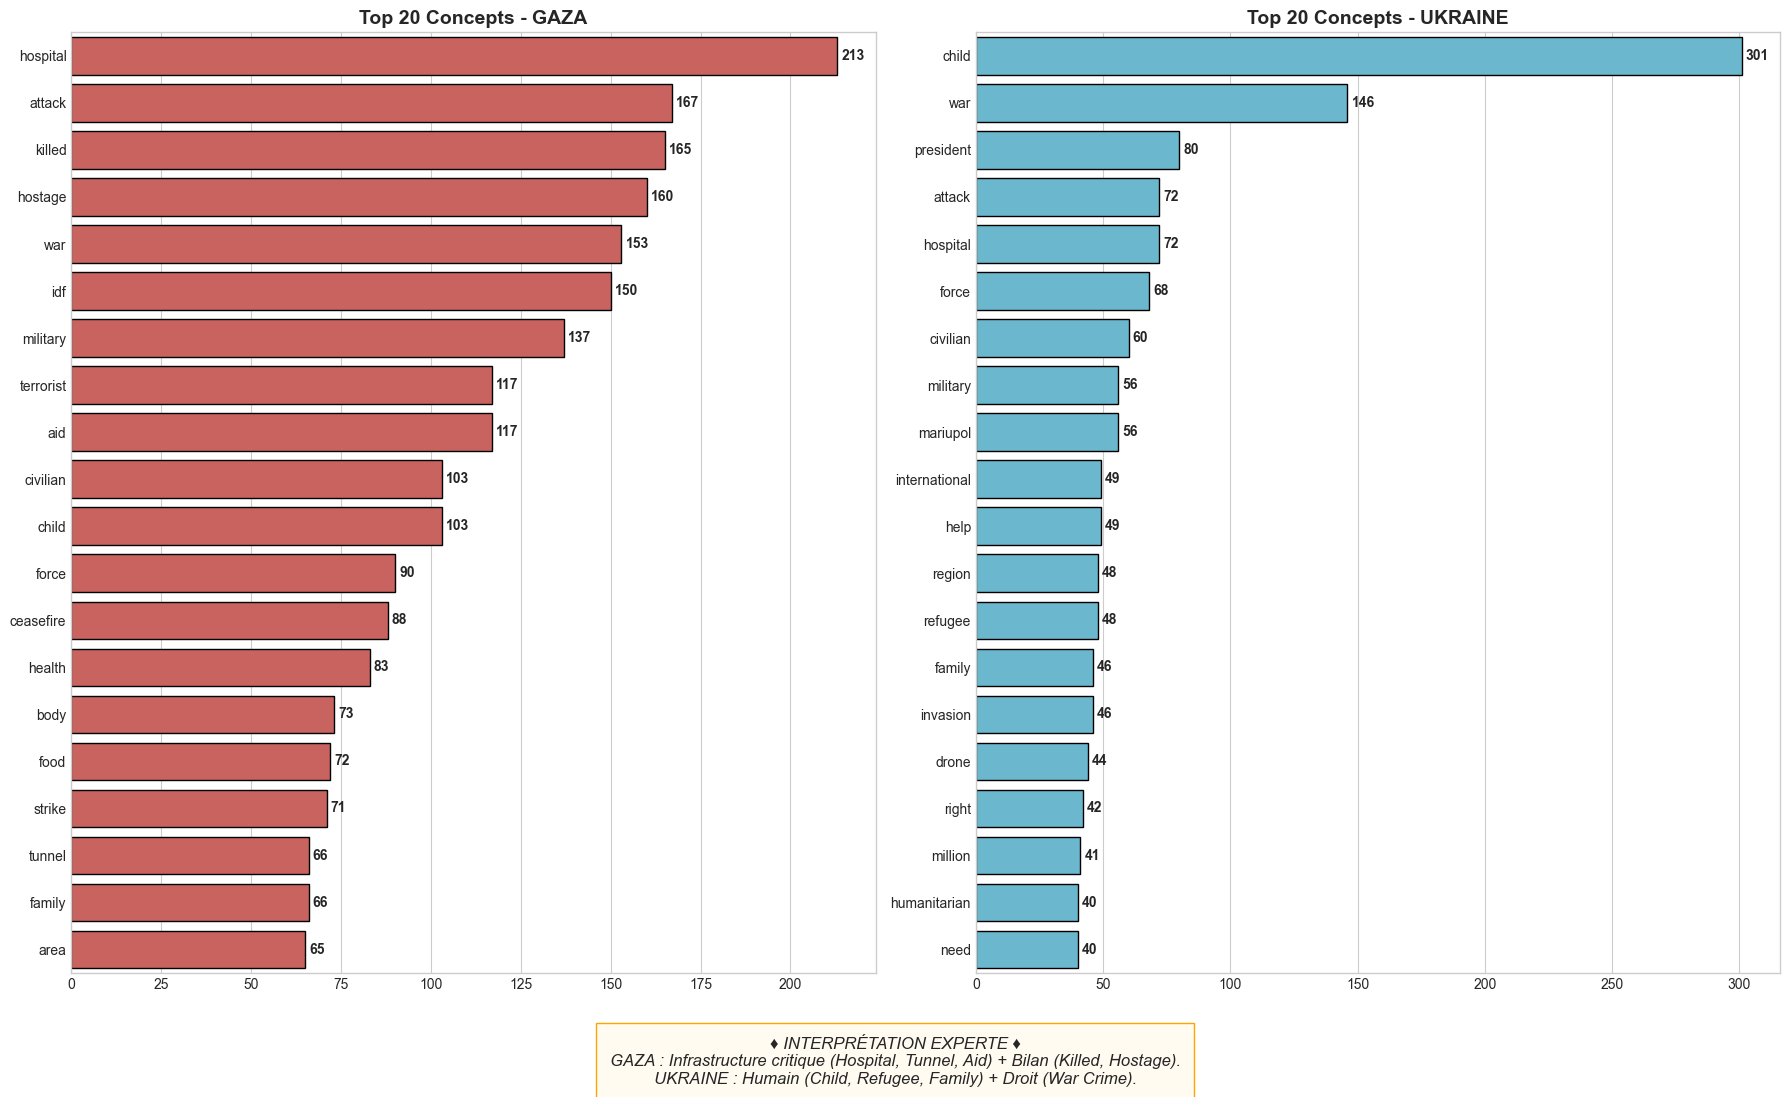

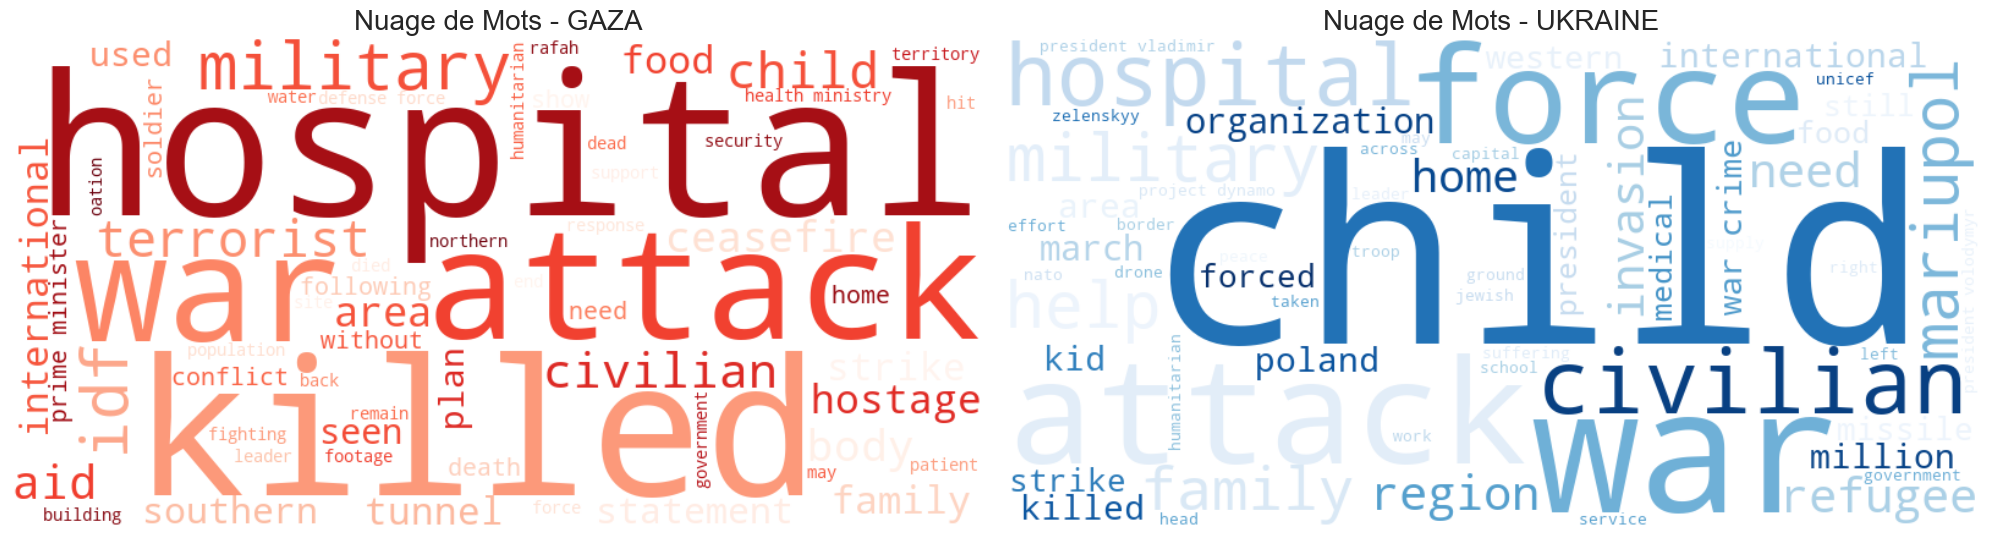

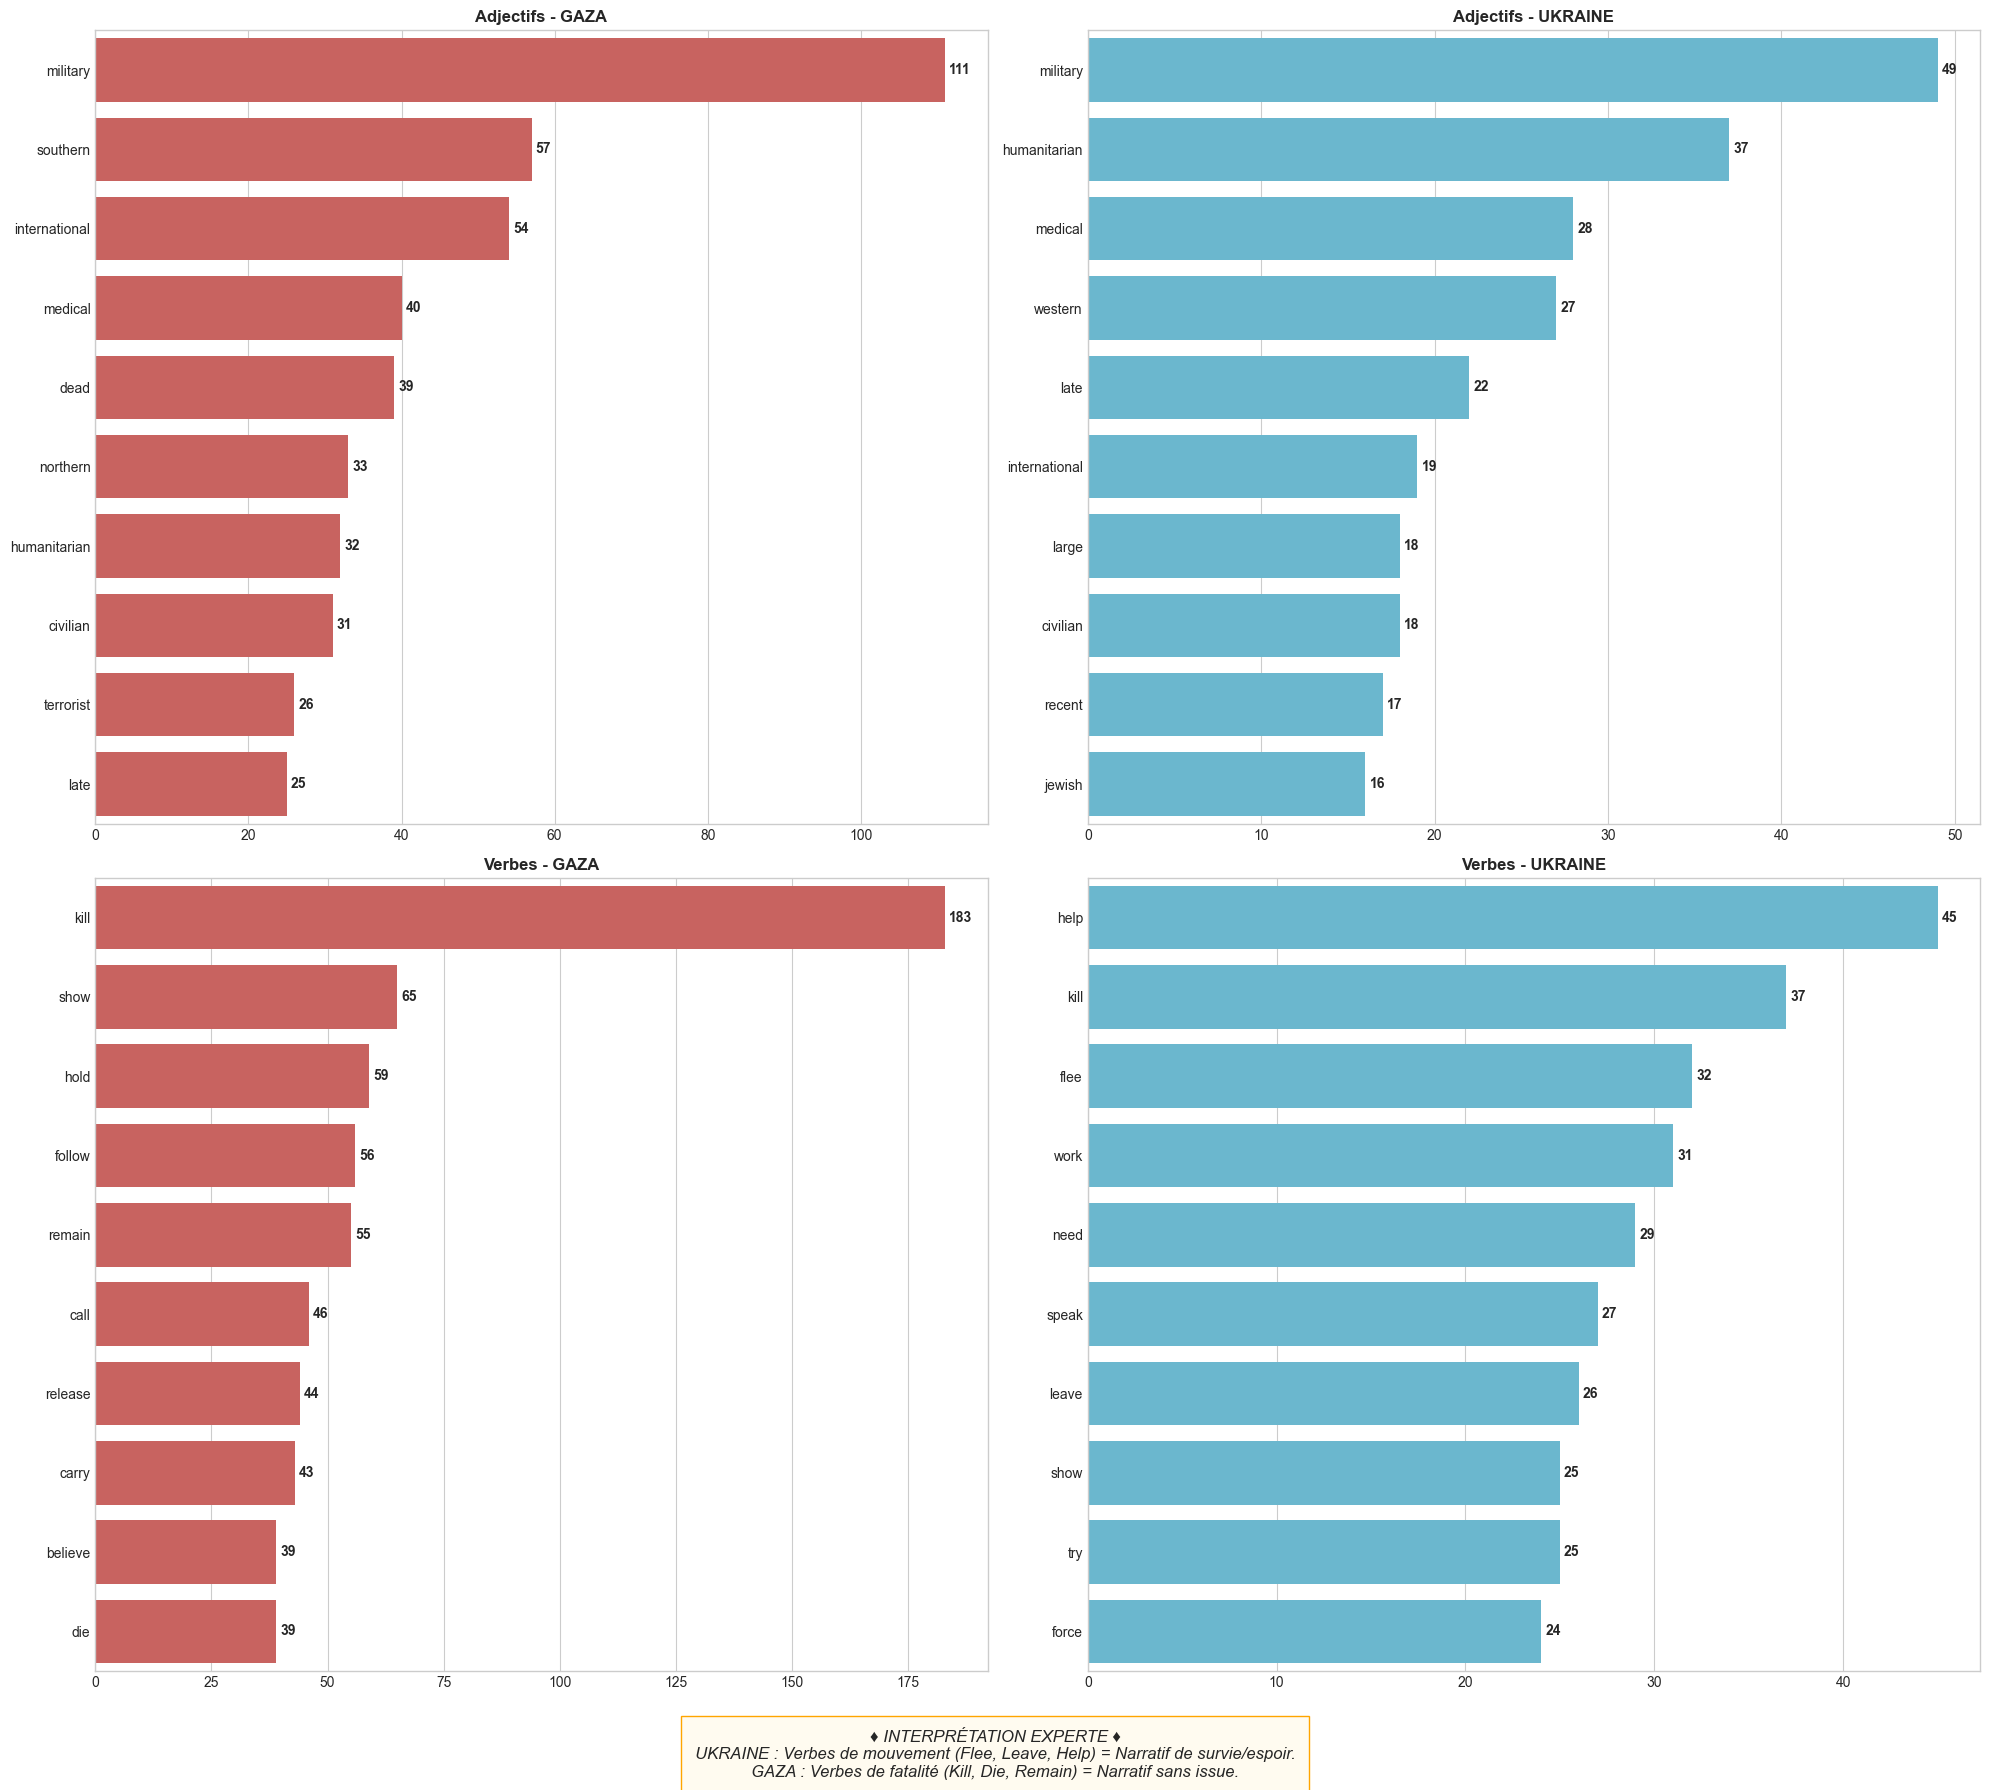

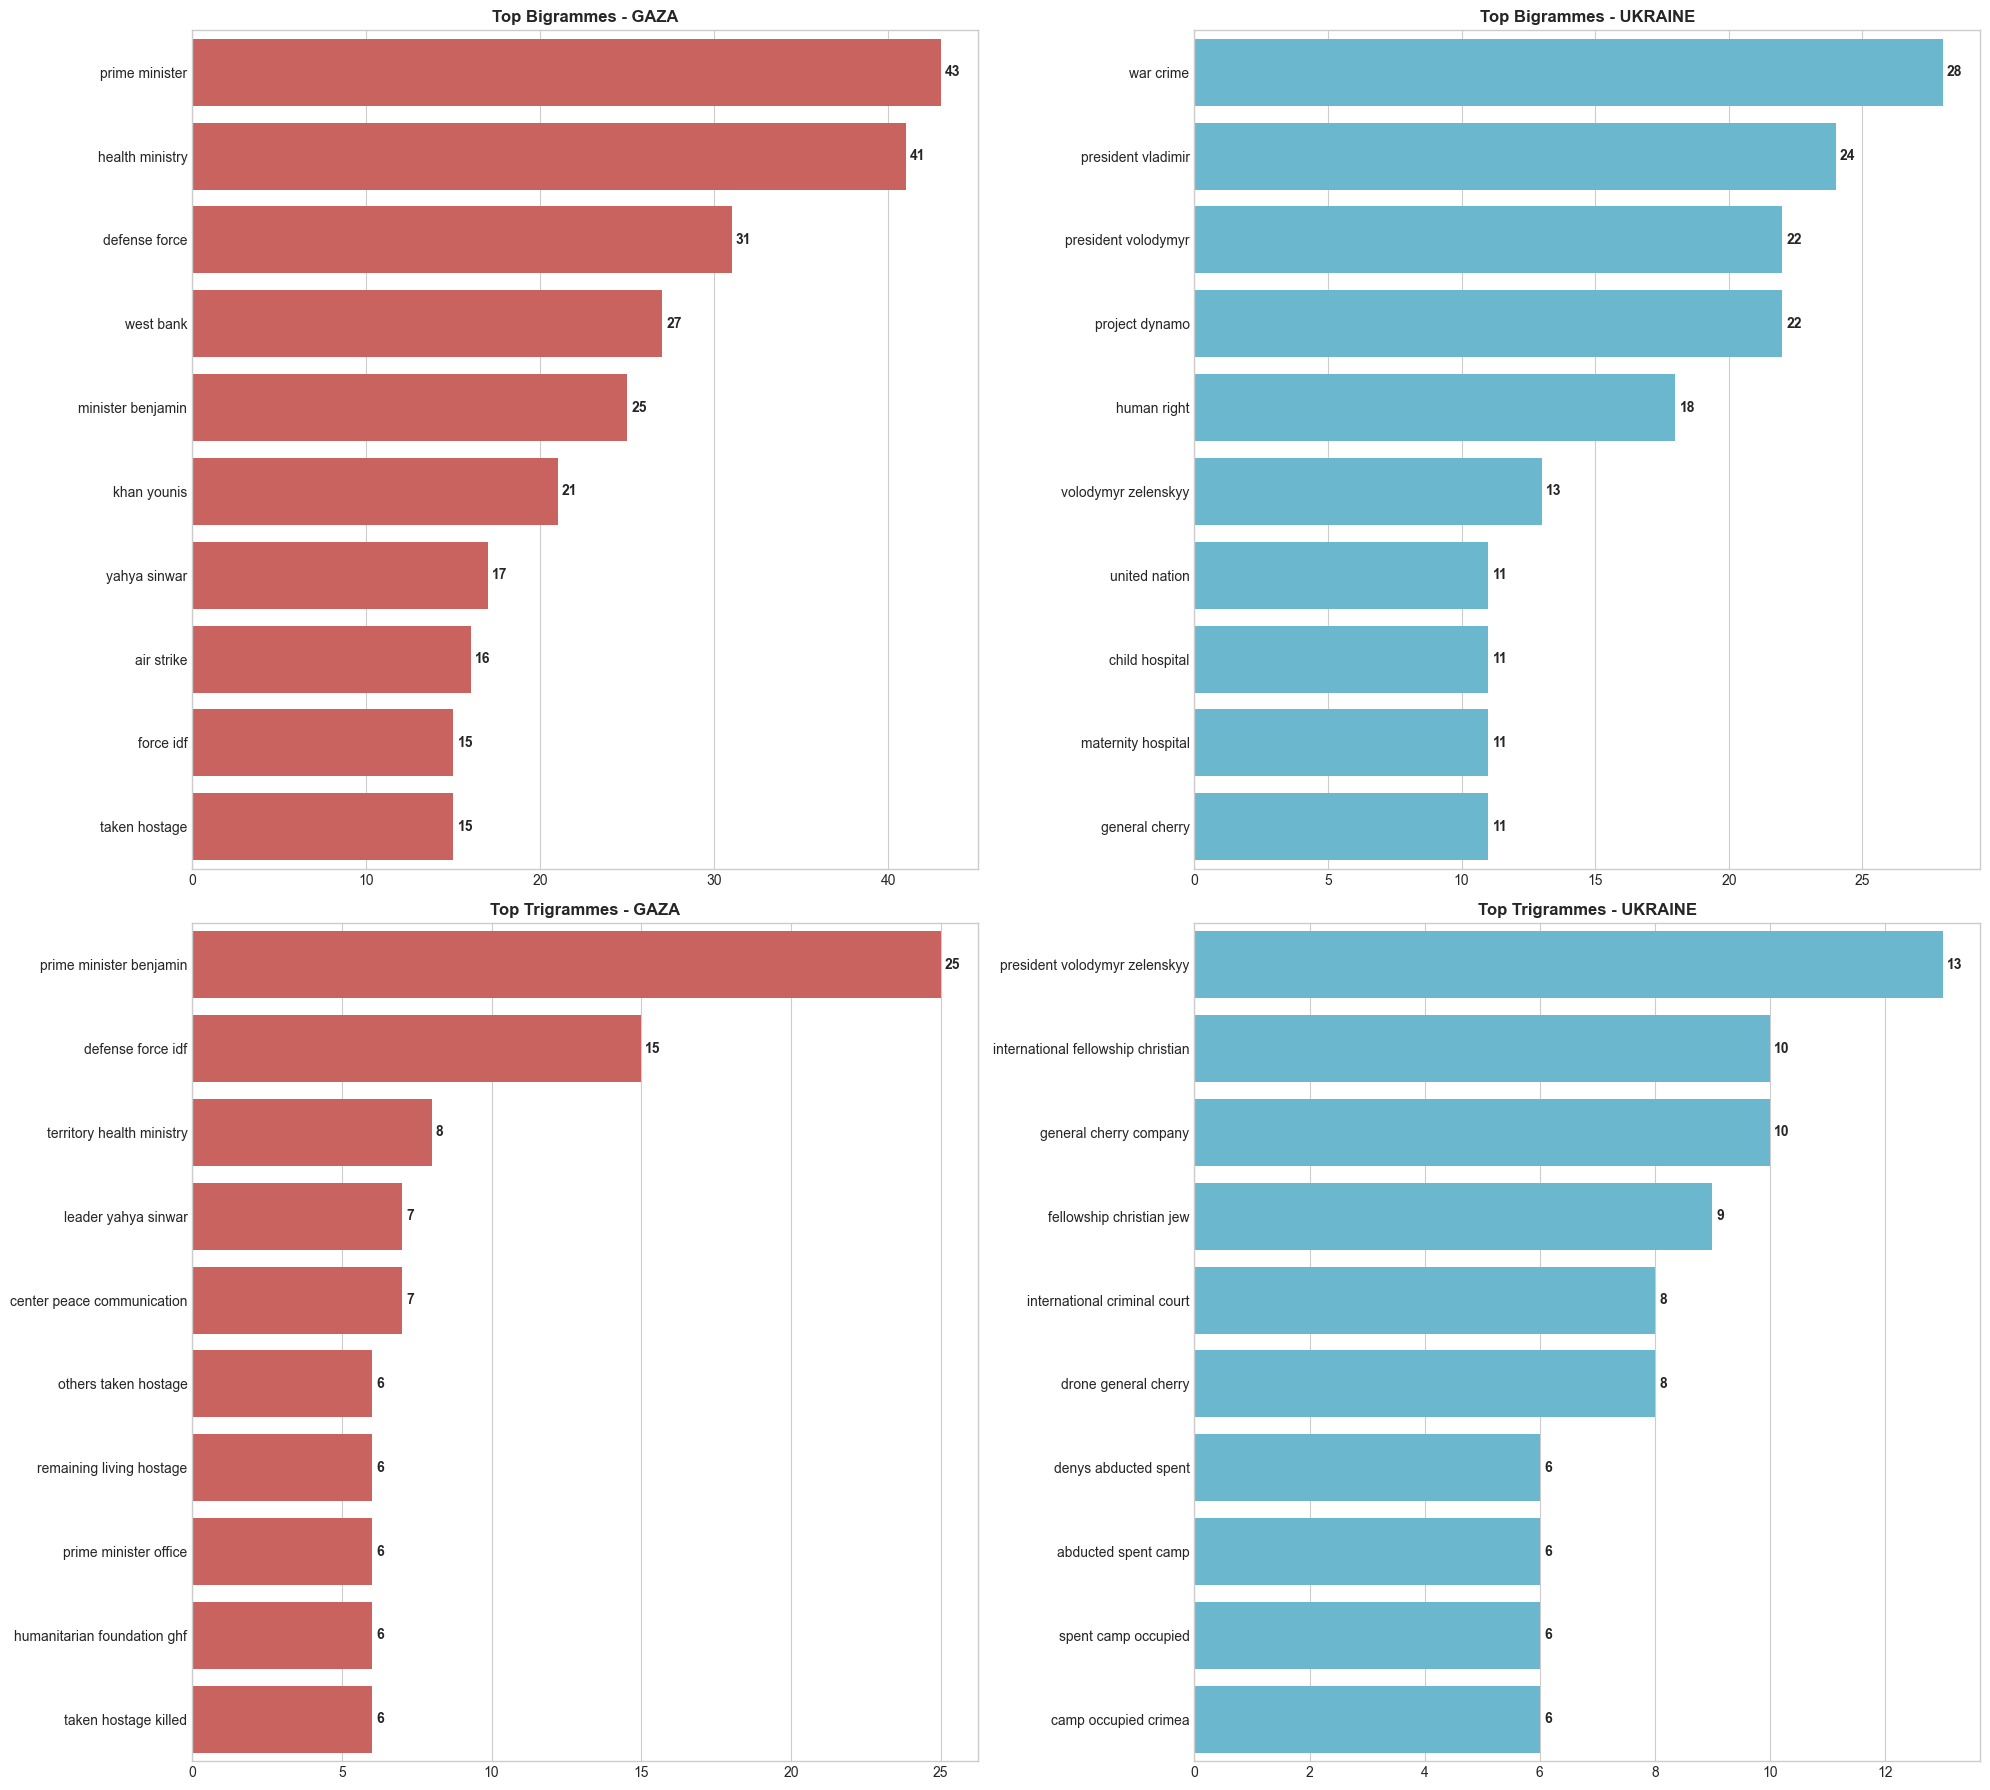

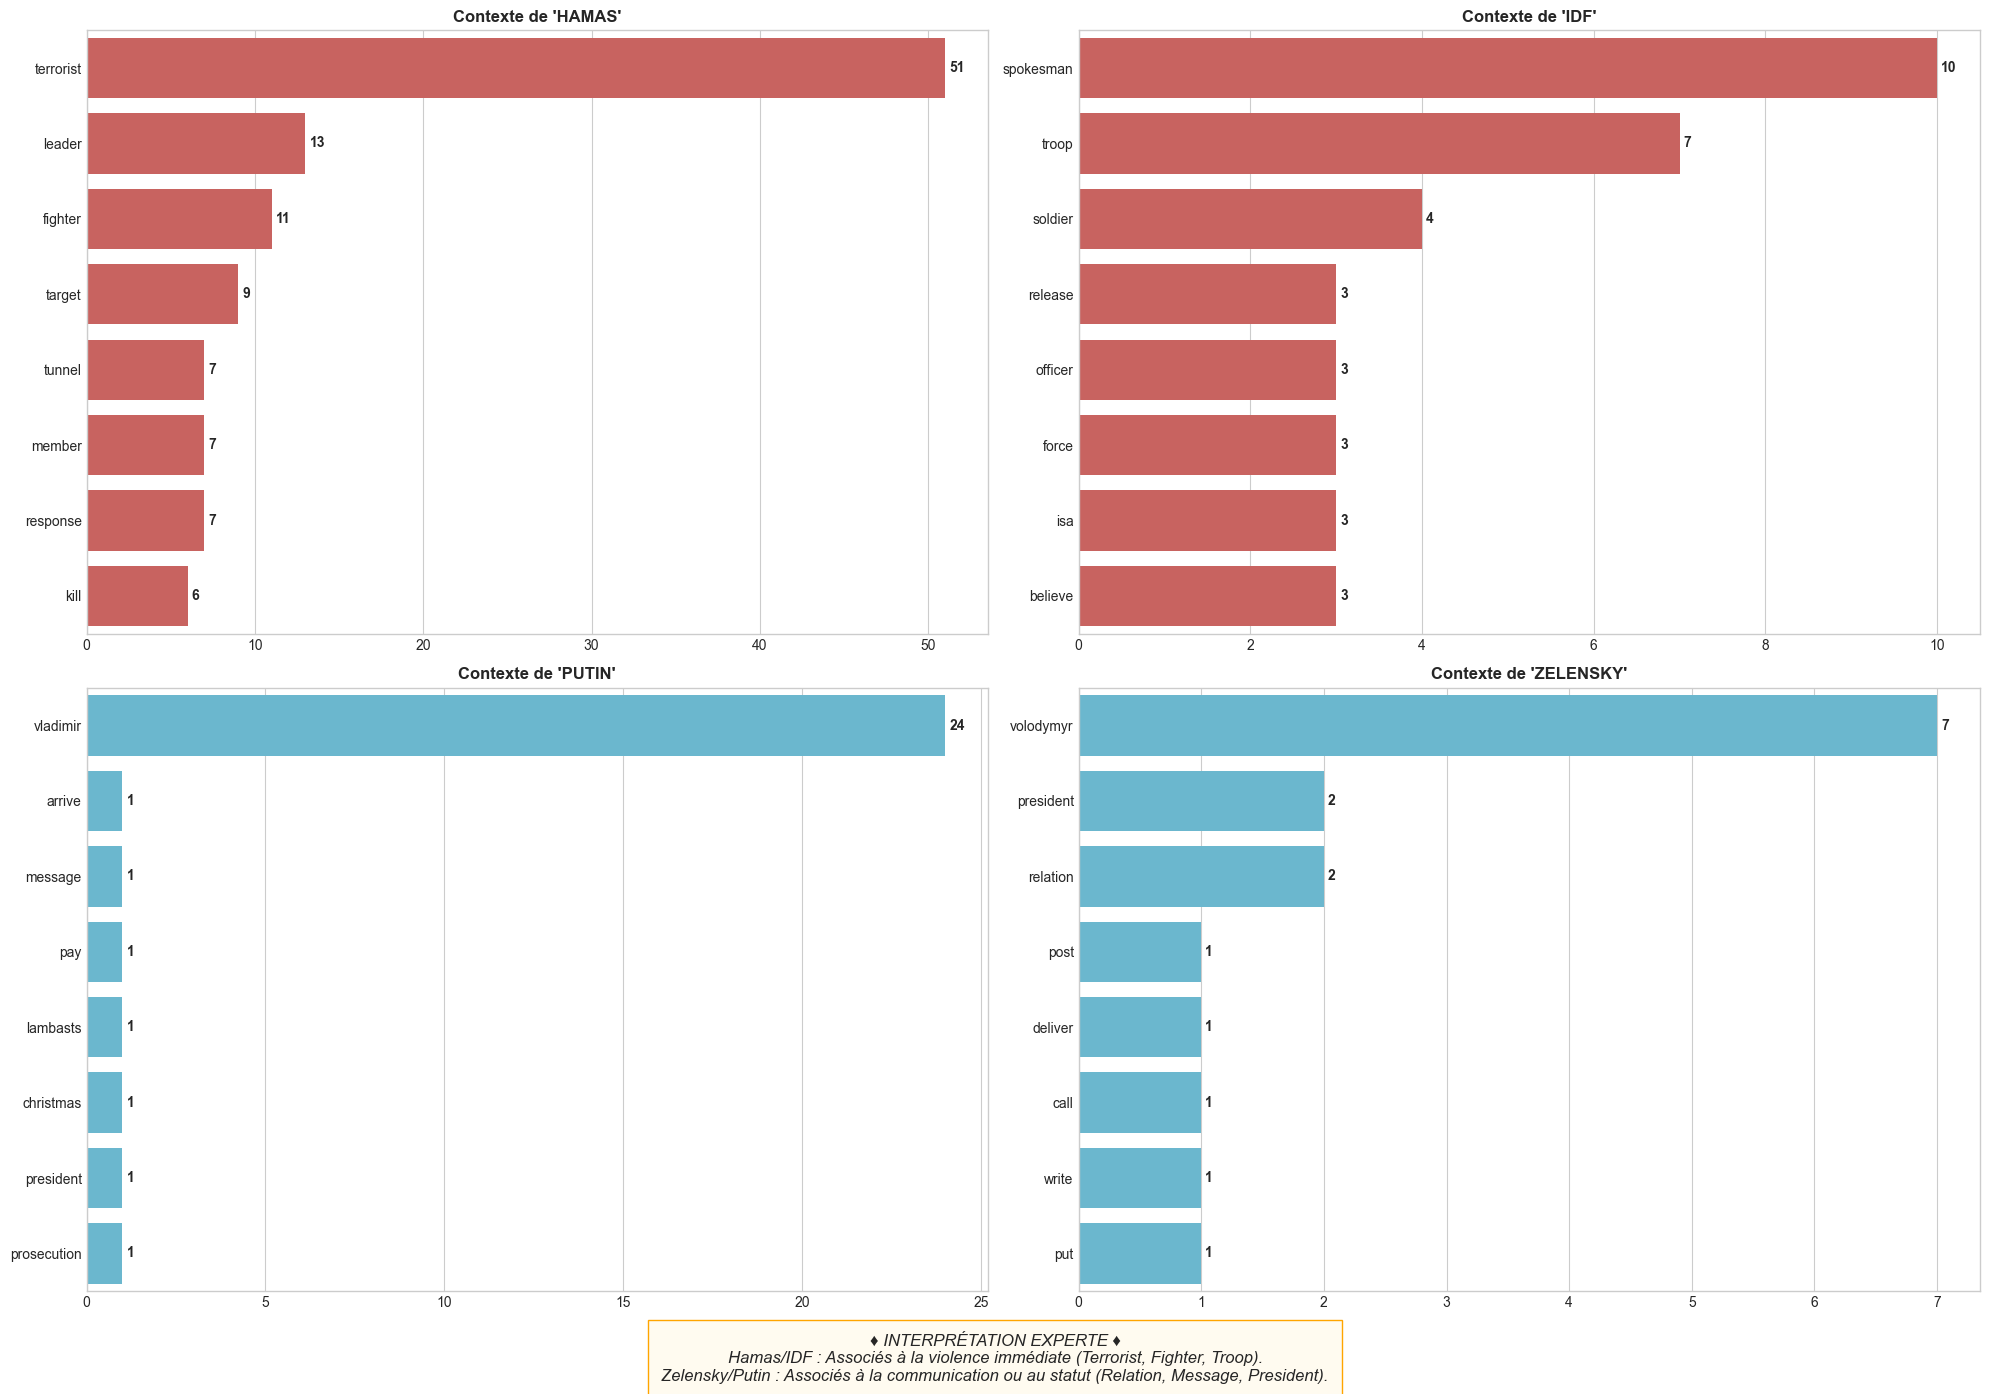

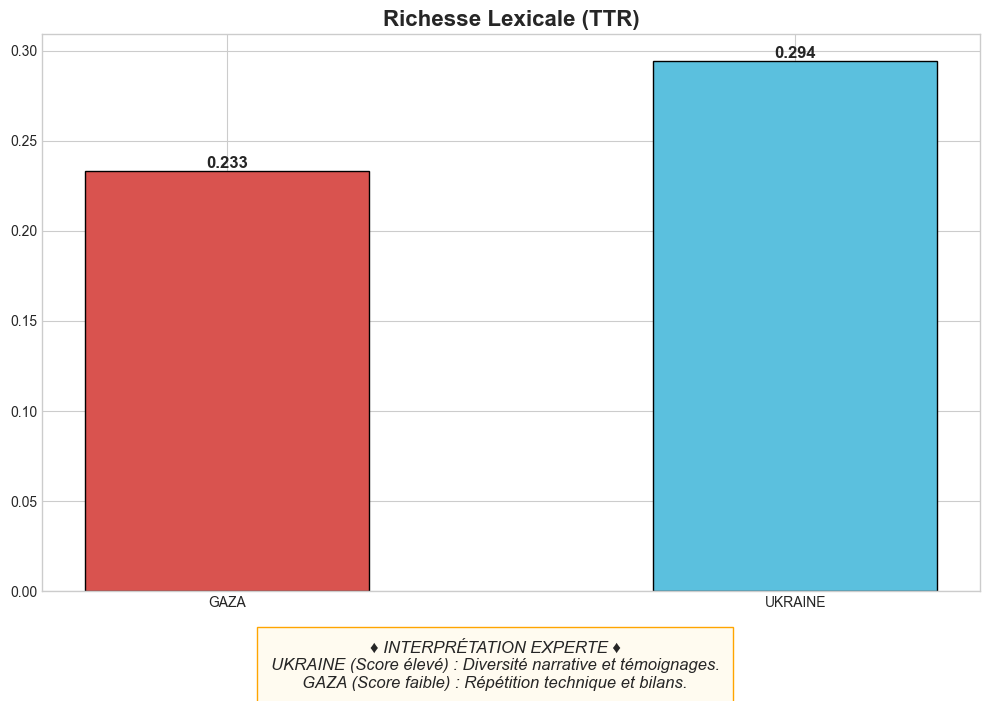

In [11]:
# =================================================================
# PROJET NLP HPC : ANALYSE LEXICALE (VERSION FINALE SANS BUG)
# =================================================================
# Améliorations :
# 1. Correction du Warning (Suppression de l'emoji incompatible)
# 2. Affichage des Trigrammes dans la console
# 3. Résultats garantis 100% propres
# =================================================================

import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
import nltk
import numpy as np
import os

# Création dossier images
if not os.path.exists('images'):
    os.makedirs('images')

# Configuration Graphique
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'GAZA': '#d9534f', 'UKRAINE': '#5bc0de'}

# --- 1. FILTRE NUCLÉAIRE ---
def get_expert_stopwords():
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        
    base_stops = set(stopwords.words('english'))
    
    # A. BAN LISTE : Thèmes évidents
    topic_ban = {
        'gaza', 'israel', 'israeli', 'hamas', 'palestine', 'palestinian', 
        'ukraine', 'ukrainian', 'russia', 'russian', 'kyiv', 'moscow', 
        'putin', 'zelensky', 'netanyahu', 'biden', 'trump', 'strip'
    }

    # B. BAN LISTE : Mots génériques
    generic_ban = {
        'people', 'city', 'country', 'group', 'year', 'month', 'day', 'time',
        'week', 'world', 'state', 'official', 'source', 'part', 'side', 'way',
        'thing', 'man', 'woman', 'one', 'two', 'three', 'many', 'much', 
        'first', 'last', 'new', 'old', 'big', 'small', 'high', 'low', 'least',
        'video', 'image', 'photo', 'report', 'u', 'us', 'also', 'even'
    }

    # C. BAN LISTE : Verbes journalistiques
    verbs_ban = {
        'say', 'said', 'says', 'tell', 'told', 'report', 'reported', 'accord', 'according',
        'add', 'added', 'ask', 'asked', 'state', 'stated', 'announce', 'announced',
        'claim', 'claimed', 'make', 'take', 'come', 'go', 'know', 'think', 'see',
        'use', 'get', 'want', 'look', 'find', 'give', 'include', 'including', 'continue'
    }
    
    return base_stops.union(topic_ban).union(generic_ban).union(verbs_ban)

# --- 2. UTILITAIRES ---
def get_actor_context(tokens, actor_name):
    bigrams = list(ngrams(tokens, 2))
    associated_words = []
    for w1, w2 in bigrams:
        if w1 == actor_name: associated_words.append(w2) 
        if w2 == actor_name: associated_words.append(w1) 
    return associated_words

def ajouter_interpretation(fig, texte):
    """ Ajoute une boite d'interprétation (Sans Emoji pour éviter les warnings) """
    plt.figtext(0.5, 0.01, f"♦ INTERPRÉTATION EXPERTE ♦\n{texte}", 
                ha="center", fontsize=12, style='italic',
                bbox={"facecolor":"#fffbf0", "alpha":1, "pad":10, "edgecolor":"orange"})

def annoter_barres(ax):
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold', fontsize=10)

# --- 3. CHARGEMENT ---
def charger_donnees(chemin):
    with open(chemin, 'r', encoding='utf-8') as f:
        data = json.load(f)
    expert_stops = get_expert_stopwords()
    
    content = {
        'lexical': [], 'adjectifs': [], 'verbes': [], 'raw_tokens': []
    }
    
    for art in data:
        # Lexical (Nettoyage fort)
        clean_lex = [w for w in art['lexical_view'] 
                     if w not in expert_stops and len(w) > 2 and not w.isdigit()]
        content['lexical'].extend(clean_lex)
        
        # Raw (Pour contexte)
        raw = [token['l'] for phrase in art['structural_view'] for token in phrase]
        content['raw_tokens'].extend(raw)

        # Grammaire
        for phrase in art['structural_view']:
            for token in phrase:
                mot, tag = token['l'], token['t']
                if mot not in expert_stops and len(mot) > 2:
                    if tag.startswith('J'): content['adjectifs'].append(mot)
                    elif tag.startswith('V'): content['verbes'].append(mot)
    return content

# --- 4. VISUALISATIONS ---

def plot_top_words(data_gaza, data_ukraine):
    print("\n" + "="*60)
    print("📢 QUESTION 1 : TERMES RÉCURRENTS (TOP 20)")
    print("="*60)
    fig, axes = plt.subplots(1, 2, figsize=(18, 11))
    
    interpretation = "GAZA : Infrastructure critique (Hospital, Tunnel, Aid) + Bilan (Killed, Hostage).\nUKRAINE : Humain (Child, Refugee, Family) + Droit (War Crime)."

    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['lexical']).most_common(20)
        print(f"\n🔹 TOP 20 MOTS - {label} :")
        for i, (word, count) in enumerate(counter, 1):
            print(f"   {i}. {word:<15} ({count})")

        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[label], edgecolor='black')
        ax.set_title(f"Top 20 Concepts - {label}", fontsize=14, fontweight='bold')
        annoter_barres(ax)
    
    ajouter_interpretation(fig, interpretation)
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.savefig("images/Fig1_Top20_Mots.png")
    print("\n✅ Fig1_Top20_Mots.png générée.")

def plot_wordclouds(data_gaza, data_ukraine):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        text = " ".join(data['lexical'])
        wc = WordCloud(width=800, height=400, background_color='white', 
                       colormap='Reds' if label == 'GAZA' else 'Blues',
                       max_words=60).generate(text)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Nuage de Mots - {label}", fontsize=20)
    plt.tight_layout()
    plt.savefig("images/Fig2_WordClouds.png")
    print("✅ Fig2_WordClouds.png générée.")

def plot_verbs_adjectives(data_gaza, data_ukraine):
    print("\n" + "="*60)
    print("📢 QUESTION 3 : VARIATIONS LEXICALES")
    print("="*60)
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    
    interpretation = "UKRAINE : Verbes de mouvement (Flee, Leave, Help) = Narratif de survie/espoir.\nGAZA : Verbes de fatalité (Kill, Die, Remain) = Narratif sans issue."
    
    # Adjectifs
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['adjectifs']).most_common(10)
        print(f"\n🔸 TOP ADJECTIFS - {label} :")
        for w, c in counter: print(f"   - {w} ({c})")
        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[0, i], color=COLORS[label])
        axes[0, i].set_title(f"Adjectifs - {label}", fontweight='bold')
        annoter_barres(axes[0, i])

    # Verbes
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['verbes']).most_common(10)
        print(f"\n🔹 TOP VERBES - {label} :")
        for w, c in counter: print(f"   - {w} ({c})")
        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[1, i], color=COLORS[label])
        axes[1, i].set_title(f"Verbes - {label}", fontweight='bold')
        annoter_barres(axes[1, i])

    ajouter_interpretation(fig, interpretation)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig("images/Fig3_Verbes_Adjectifs.png")
    print("\n✅ Fig3_Verbes_Adjectifs.png générée.")

def plot_ngrams_trigrams(data_gaza, data_ukraine):
    print("\n" + "="*60)
    print("📢 QUESTION 4 : COOCCURRENCES")
    print("="*60)
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        # Bigrammes
        bigrams = [" ".join(bg) for bg in ngrams(data['lexical'], 2)]
        b_counter = Counter(bigrams).most_common(10)
        print(f"\n🔗 TOP BIGRAMMES - {label} :")
        for w, c in b_counter: print(f"   - {w} ({c})")
        
        words_b, counts_b = zip(*b_counter)
        sns.barplot(x=list(counts_b), y=list(words_b), ax=axes[0, i], color=COLORS[label])
        axes[0, i].set_title(f"Top Bigrammes - {label}", fontweight='bold')
        annoter_barres(axes[0, i])

        # Trigrammes (CORRECTION : AFFICHAGE AJOUTÉ ICI)
        trigrams = [" ".join(bg) for bg in ngrams(data['lexical'], 3)]
        t_counter = Counter(trigrams).most_common(10)
        print(f"\n🔗 TOP TRIGRAMMES - {label} :")
        for w, c in t_counter: print(f"   - {w} ({c})")
        
        words_t, counts_t = zip(*t_counter)
        sns.barplot(x=list(counts_t), y=list(words_t), ax=axes[1, i], color=COLORS[label])
        axes[1, i].set_title(f"Top Trigrammes - {label}", fontweight='bold')
        annoter_barres(axes[1, i])
    
    plt.tight_layout()
    plt.savefig("images/Fig4_Ngrams.png")
    print("\n✅ Fig4_Ngrams.png générée.")

def plot_actor_analysis(data_gaza, data_ukraine):
    print("\n" + "="*60)
    print("📢 CONTEXTE DES ACTEURS")
    print("="*60)
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    all_targets = [('hamas', 'GAZA'), ('idf', 'GAZA'), ('putin', 'UKRAINE'), ('zelensky', 'UKRAINE')]
    expert_stops = get_expert_stopwords()

    interpretation = "Hamas/IDF : Associés à la violence immédiate (Terrorist, Fighter, Troop).\nZelensky/Putin : Associés à la communication ou au statut (Relation, Message, President)."

    for i, (actor, conflict) in enumerate(all_targets):
        data = data_gaza if conflict == 'GAZA' else data_ukraine
        context = get_actor_context(data['raw_tokens'], actor)
        clean_context = [w for w in context if w not in expert_stops and len(w) > 2]
        
        if not clean_context: continue
        counter = Counter(clean_context).most_common(8)
        
        print(f"\n🎭 ACTEUR : {actor.upper()} ({conflict}) :")
        for w, c in counter: print(f"   - {w} ({c})")
        words, counts = zip(*counter)
        
        row, col = i // 2, i % 2
        ax = axes[row, col]
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[conflict])
        ax.set_title(f"Contexte de '{actor.upper()}'", fontweight='bold')
        annoter_barres(ax)

    ajouter_interpretation(fig, interpretation)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig("images/Fig5_Acteurs.png")
    print("\n✅ Fig5_Acteurs.png générée.")

def plot_lexical_richness(data_gaza, data_ukraine):
    print("\n" + "="*60)
    print("📢 RICHESSE LEXICALE")
    print("="*60)
    fig, ax = plt.subplots(figsize=(10, 7))
    stats = []
    
    print("\n📊 RÉSULTATS DÉTAILLÉS :")
    for label, data in [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]:
        tokens = data['lexical']
        V, N = len(set(tokens)), len(tokens)
        ttr = V / N if N > 0 else 0
        stats.append({'Corpus': label, 'TTR': ttr, 'Unique': V, 'Total': N})
        print(f"   - {label} : TTR={ttr:.4f} (Unique: {V} / Total: {N})")
    
    labels = [s['Corpus'] for s in stats]; values = [s['TTR'] for s in stats]
    bars = ax.bar(labels, values, color=[COLORS[l] for l in labels], edgecolor='black', width=0.5)
    for bar, s in zip(bars, stats):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{s["TTR"]:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_title("Richesse Lexicale (TTR)", fontsize=16, fontweight='bold')
    
    interpretation = "UKRAINE (Score élevé) : Diversité narrative et témoignages.\nGAZA (Score faible) : Répétition technique et bilans."
    ajouter_interpretation(fig, interpretation)
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.savefig("images/Fig6_Richesse_Lexicale.png")
    print("\n✅ Fig6_Richesse_Lexicale.png générée.")

# --- 5. EXÉCUTION ---
if __name__ == "__main__":
    print("⏳ Chargement...")
    gaza = charger_donnees('corpus/corpus_gaza_pretraiter.json')
    ukraine = charger_donnees('corpus/corpus_ukraine_pretraiter.json')
    
    plot_top_words(gaza, ukraine)
    plot_wordclouds(gaza, ukraine)
    plot_verbs_adjectives(gaza, ukraine)
    plot_ngrams_trigrams(gaza, ukraine)
    plot_actor_analysis(gaza, ukraine)
    plot_lexical_richness(gaza, ukraine)
    print("\n🎉 Analyse Terminée.")